In [1]:
 !pip install vit_keras tensorflow_addons tensorflow pytorch-gradcam torchcam alibi

In [2]:
import os, random
import pandas as pd
import numpy as np
import itertools, cv2
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, LayerNormalization, Flatten, BatchNormalization, Dropout, GaussianNoise, Conv2D, GaussianDropout
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from vit_keras import vit
import matplotlib.pyplot as plt
import tensorflow as tf
from alibi.explainers import IntegratedGradients
from alibi.explainers import AnchorImage
from tensorflow.python.framework import ops

2024-04-30 06:58:47.730636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 06:58:47.730701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 06:58:47.732195: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [3]:
dataset_name = "eye-disease"
dataset_paths = [
    '/kaggle/input/eye-diseases-classification'
]

In [4]:
HIDDEN_LAYERS = [] #512,256,128
USE_HIDDEN_LAYERS = True
PIC_SIZE = (224, 224)
INPUT_SHAPE = (*PIC_SIZE, 3)
BATCH_SIZE = 16
EPOCHS = 30

In [5]:
from collections import defaultdict

count_dist = defaultdict(int)
original_images = []
labels = []

# Spliting by my self later
for path in dataset_paths:
    for dirpath, _, filenames in os.walk(path):
        for i, filename in enumerate(filenames):
            image = cv2.imread(os.path.join(dirpath, filename))
            image = cv2.resize(image, PIC_SIZE, interpolation = cv2.INTER_AREA)
            #image = cv2.addWeighted(image, 1.2, image, -0.15,-0.15) 
            label = dirpath.split('/')[-1]
            
            #if count_dist[label] >= 400 or label not in ["diabetic_retinopathy","normal"]: continue
            count_dist[label] += 1
            original_images.append(image)
            labels.append(label)
            
len(original_images), len(labels)

(4217, 4217)

In [6]:
img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
]

def img_augmentation(images, k=1):
    results = []
    for i in range(k):
        x = images
        for layer in img_augmentation_layers:
            x = layer(x)
        results.extend(x)
    
    return results

In [7]:
data_dict = defaultdict(list)
aug_dict = defaultdict(list)

for i, img in enumerate(original_images):
    data_dict[labels[i]].append(img)

for k, _images in data_dict.items():
    aug_dict[k] = img_augmentation(_images, k=0)

all_images = original_images
all_labels = labels
for label, items in aug_dict.items():
    size = len(items)
    aug_labels = [label for i in range(size)]
    all_images.extend(items)
    all_labels.extend(aug_labels)
    
original_images=all_images
labels=all_labels
len(original_images), len(labels)

(4217, 4217)

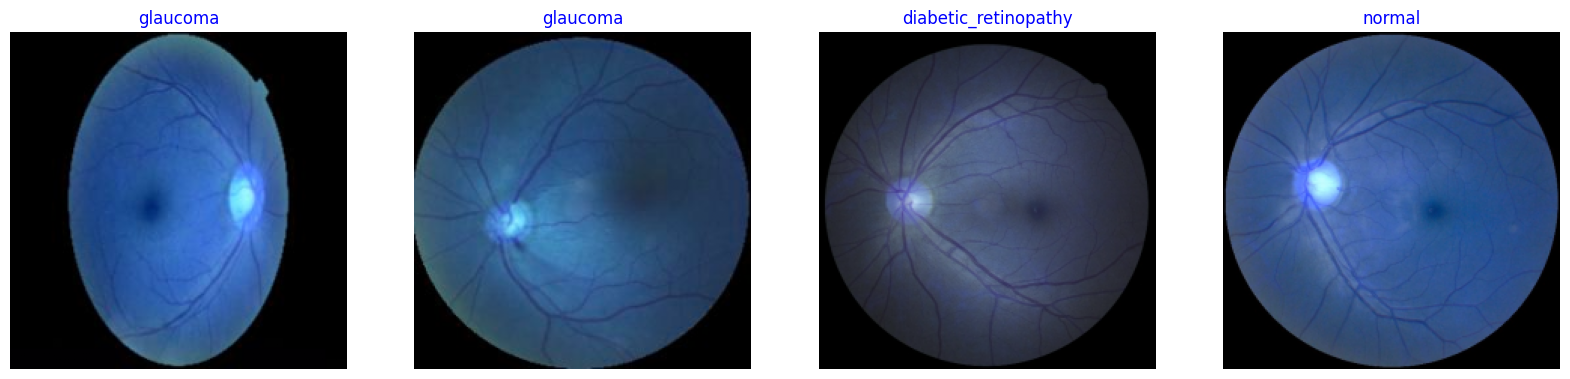

In [8]:
def visualize_datasets(images, labels, k=4, seed=42):
    # visualize datasets
    plt.figure(figsize=(20, 20))
    random.seed(seed)
    samples = random.sample(list(range(len(images))), k)
    for stt, i in enumerate(samples):
        plt.subplot(2, k, stt + 1)
        plt.imshow(images[i] / 255)
        class_name = labels[i]
        plt.title(class_name, color = 'blue' , fontsize=12)
        plt.axis('off')

    plt.show()

images = original_images
visualize_datasets(images, labels)

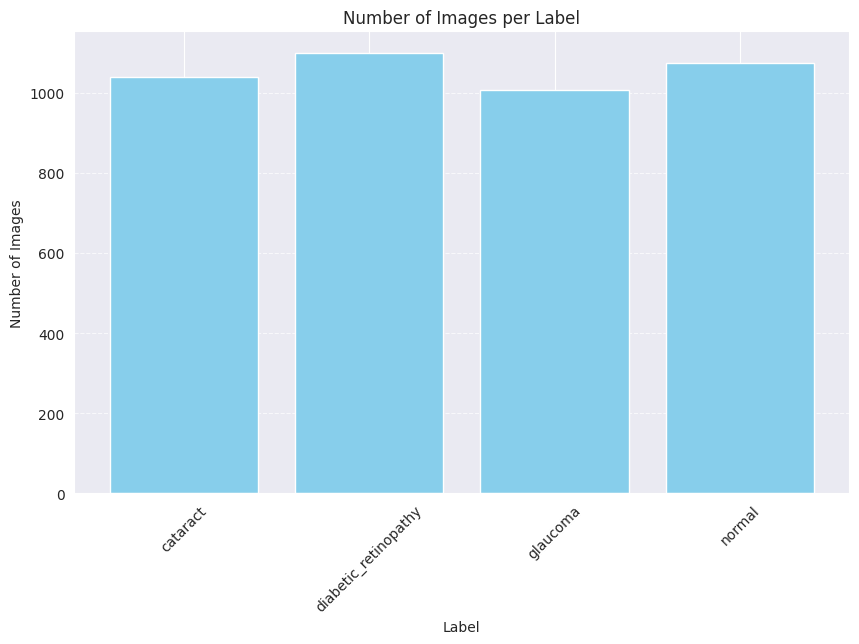

In [9]:
def visualize_datasets(images, labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.title('Number of Images per Label')
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
visualize_datasets(images, labels)

In [10]:
classes = sorted(set(labels))
label_dict = { v: i for i, v in enumerate(classes) }
classes, label_dict

(['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal'],
 {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3})

In [11]:
# Convert labels to numpy array
images = np.stack(images, axis=0)
labels = np.array([label_dict[label] for label in labels])

images.shape, labels.shape, labels[:20]

((4217, 224, 224, 3),
 (4217,),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [12]:
def count_labels(labels):
    count_dict = defaultdict(int)
    for label in labels:
        count_dict[label] += 1
    return count_dict

In [13]:
# Split the data into training and remaining sets (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels)
# Split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp)

[
    x_train.shape,
    x_val.shape, 
    x_test.shape, 
    y_train.shape , 
    y_val.shape , 
    y_test.shape, 
    count_labels(y_train),
    count_labels(y_val),
    count_labels(y_test), 
]

[(3373, 224, 224, 3),
 (422, 224, 224, 3),
 (422, 224, 224, 3),
 (3373,),
 (422,),
 (422,),
 defaultdict(int, {3: 859, 2: 806, 1: 878, 0: 830}),
 defaultdict(int, {1: 110, 2: 100, 0: 104, 3: 108}),
 defaultdict(int, {2: 101, 3: 107, 1: 110, 0: 104})]

In [14]:
def plot_acc(model_history, epochs, name):
    print('\n\n')
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [15]:
def plot_loss(model_history, epochs, name):
    print('\n\n')
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss", )
    plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
    plt.title("Training Loss - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [16]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plot the confusion matrix
    class_count = len(classes)
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) 

    row_sums = cm.sum(axis=1)
    cm = cm / row_sums[:, np.newaxis]

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='.2%', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [17]:
def predict(model):
    print('\nPredicting test set classes.')
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test set score:', scores)
    predictions = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
    print('Done.')
    return np.argmax(predictions, axis=1)

In [18]:
def calculate_metrics(y_true, y_pred):
    
    print("Visualize: y_true, y_pred top 20")
    print('Y_true', [i for i in y_true[:20]])
    print('Y_pred', [j for j in y_pred[:20]])
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred)
    print("ACC:       {}".format(accuracy))

    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision: {}".format(precision))

    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall:    {}".format(recall))

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1:        {}".format(f1))
    

In [19]:
def transfer_learning(model, name):
    
    best_weights_ph1 = f"{dataset_name}_{name}_ph1_weights.keras"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph1,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    callbacks_earlystoping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        verbose=1,
        mode='max',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )
    
    history = model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [callbacks_checkpoint]
    )
    
    best_acc_ph1 = max(history.history["val_accuracy"])
    print('\n\nMax validation accuracy:', best_acc_ph1)

    print('\nRestoring best weights and predicting validation set.')
    model.load_weights(best_weights_ph1)
    y_pred = predict(model)
    
    plot_acc(history, EPOCHS, f"\n Transfer Learning - ACC: {name} PhA.")
    plot_loss(history, EPOCHS, f"\n Transfer Learning - LOSS: {name} PhA.")
    
    return history, model, best_acc_ph1, y_pred

In [20]:
def fine_turning(model, name, best_acc_ph1):
    
    best_weights_ph2 = f"{dataset_name}_{name}_ph2_weights.keras"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph2,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    callbacks_earlystoping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        verbose=1,
        mode='max',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )
    
    for layer in model.layers[-20:]:
         if not isinstance(layer, LayerNormalization):
            layer.trainable = True

    #model.trainable = True
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [callbacks_checkpoint]
    )
    
    best_acc_ph2 = max(history.history["val_accuracy"])
    print('\n\nMax validation accuracy:', best_acc_ph2)
    
    # Nếu giai đoạn 2 có kết quả tốt hơn giai đoạn 1 thì phục hồi kết quả của giai đoạn 2 để thực hiện predict
    if best_acc_ph2 > best_acc_ph1:
        print('\nPhase 2 resulted in better accuracy than Phase 1.')
        print('Restoring best weights of Ph2 and predicting validation set.')
        model.load_weights(best_weights_ph2)
    
    y_pred = predict(model)
    
    plot_acc(history, EPOCHS, f"\n Fine Turning - ACC: {name} PhB.")
    plot_loss(history, EPOCHS, f"\n Fine Turning - LOSS: {name} PhB.")
    
    return history, model, best_acc_ph2, y_pred

In [21]:
initial_models = dict(
    #EfficientNetB3=tf.keras.applications.EfficientNetB3,
    #ResNet50=tf.keras.applications.resnet50.ResNet50,
    #VGG16=tf.keras.applications.VGG16,
    MobileNet=tf.keras.applications.mobilenet.MobileNet,
    InceptionV3=tf.keras.applications.inception_v3.InceptionV3,
    EfficientNetV2L=tf.keras.applications.EfficientNetV2L,
)

base_model_kwargs = dict(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='max',
    classifier_activation="softmax",
)

# custom kwargs for each model here 
initial_models_kwargs = dict(
    EfficientNetB3={ **base_model_kwargs },
    ResNet50={ **base_model_kwargs },
    VGG16={ **base_model_kwargs },
    MobileNet={ **base_model_kwargs },
    InceptionV3={ **base_model_kwargs },
    EfficientNetV2L={ **base_model_kwargs },
    VitB16=dict(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
    ),
    VitB32=dict(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
    ),
)

17225924/17225924 [==============================] - 0s 0us/step


 ==========Start Process with model MobileNet=========
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
 

I0000 00:00:1714460393.324585    2203 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


211/211 [==============================] - ETA: 0s - loss: 0.9403 - accuracy: 0.6339
Epoch 1: val_accuracy improved from -inf to 0.74882, saving model to eye-disease_MobileNet_ph1_weights.keras
211/211 [==============================] - 9s 22ms/step - loss: 0.9403 - accuracy: 0.6339 - val_loss: 0.6399 - val_accuracy: 0.7488
Epoch 2/30
209/211 [============================>.] - ETA: 0s - loss: 0.6347 - accuracy: 0.7374
Epoch 2: val_accuracy improved from 0.74882 to 0.77251, saving model to eye-disease_MobileNet_ph1_weights.keras
211/211 [==============================] - 3s 16ms/step - loss: 0.6353 - accuracy: 0.7373 - val_loss: 0.5725 - val_accuracy: 0.7725
Epoch 3/30
209/211 [============================>.] - ETA: 0s - loss: 0.5508 - accuracy: 0.7682
Epoch 3: val_accuracy improved from 0.77251 to 0.78910, saving model to eye-disease_MobileNet_ph1_weights.keras
211/211 [==============================] - 3s 16ms/step - loss: 0.5520 - accuracy: 0.7673 - val_loss: 0.5303 - val_accuracy: 0

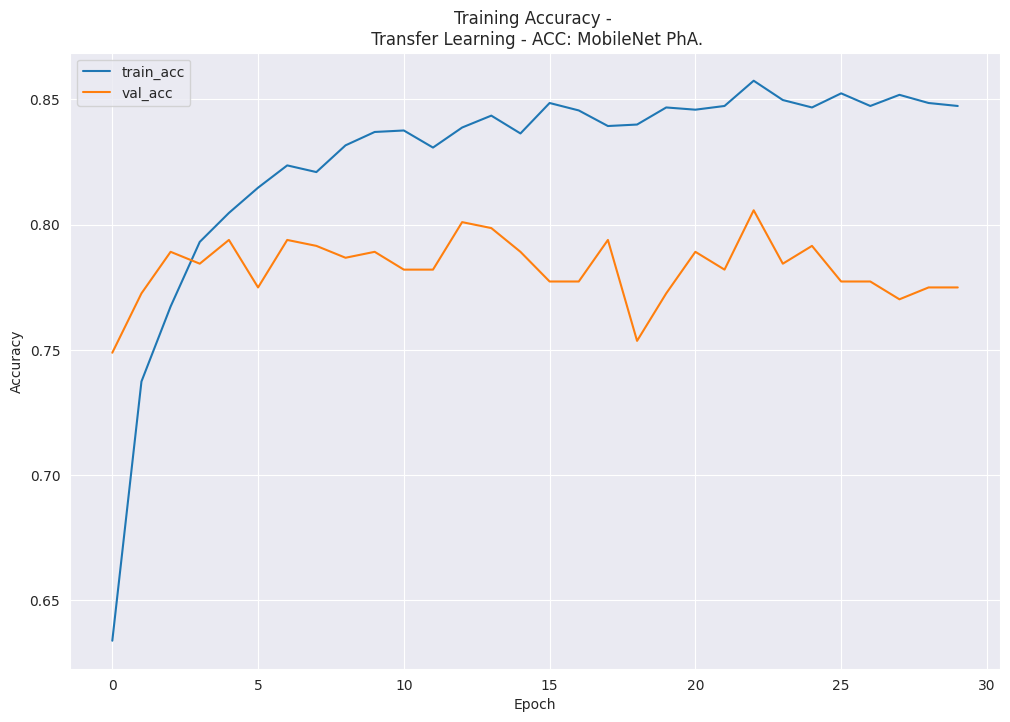

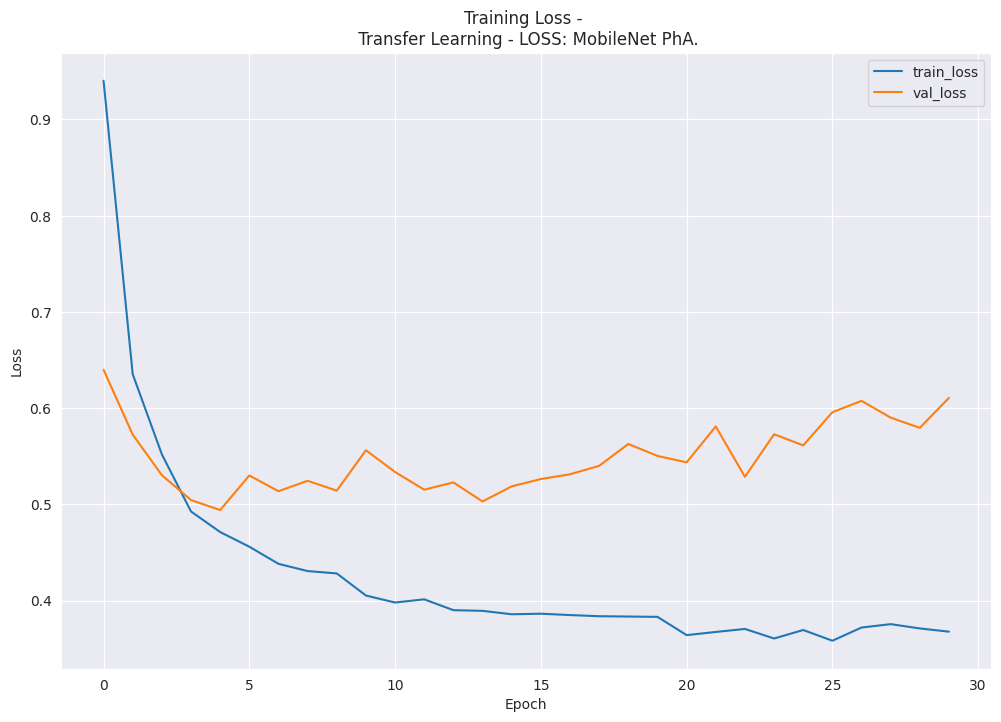

Visualize: y_true, y_pred top 20
Y_true [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 2, 1]
Y_pred [0, 3, 3, 3, 2, 2, 1, 0, 2, 3, 3, 2, 0, 1, 0, 1, 3, 3, 3, 1]
ACC:       0.7464454976303317
Precision: 0.7449902782841171
Recall:    0.7464454976303317
F1:        0.7442464311550115


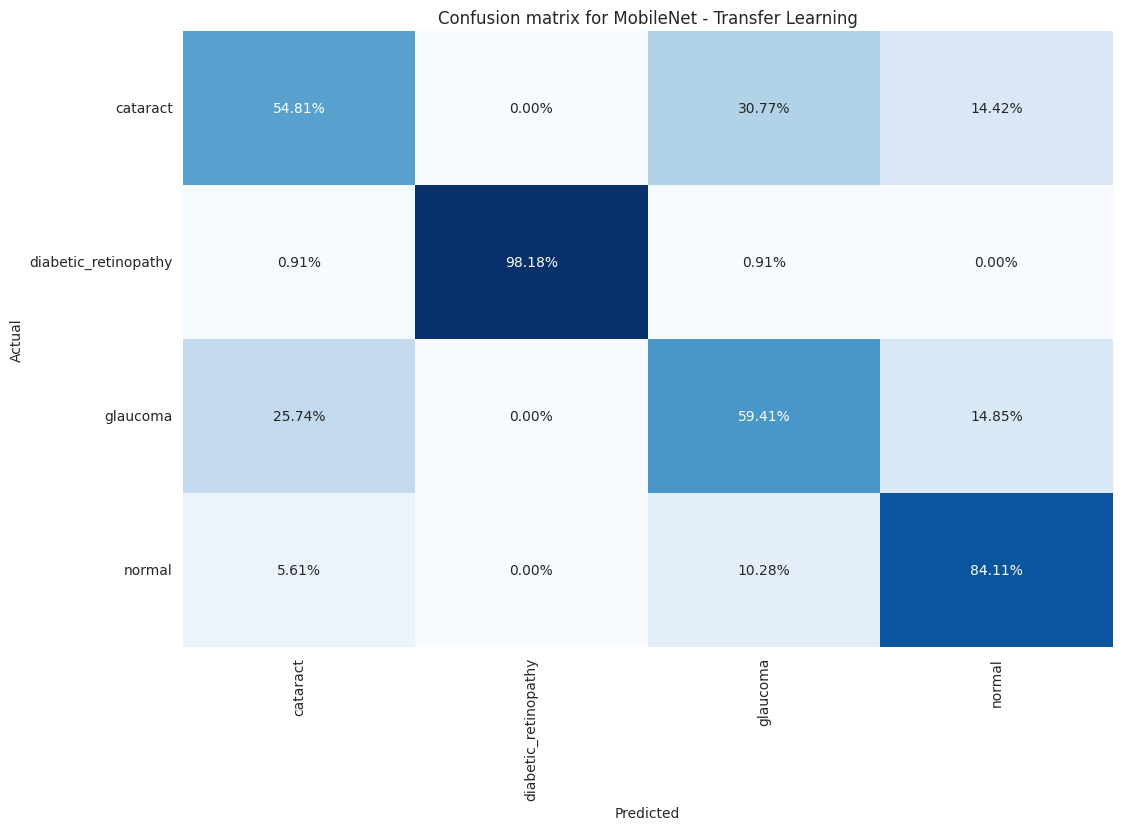

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Epoch 1/30
211/211 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.6801
Epoch 1: val_accuracy improved from -inf to 0.53318, saving model to eye-disease_MobileNet_ph2_weights.keras
211/211 [==============================] - 10s 23ms/step - loss: 1.0296 - accuracy: 0.6801 - val_loss: 1.1092 - val_accuracy: 0.5332
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.7424
Epoch 2: val_accuracy improved from 0.53318 to 0.69194, saving model to eye-disease_MobileNet_ph2_weights.keras
211/211 [==============================] - 4s 19ms/step - loss: 0.6830 - accuracy: 0.7424 - val_loss: 0.8652 - val_accuracy: 0.6919
Epoch 3/30
209/211 [============================>.] - ETA: 0s - loss: 0.6097 - accuracy: 0.7670
Epoch 3: val_accuracy did not improve from 0.69194
211/211 [==============================] - 4s 18ms/step - loss: 0.6106 - accuracy: 0.7658 - val_loss: 1.2821 - val_accuracy: 0.6422
Epoch 4/30
209/211 [=======================

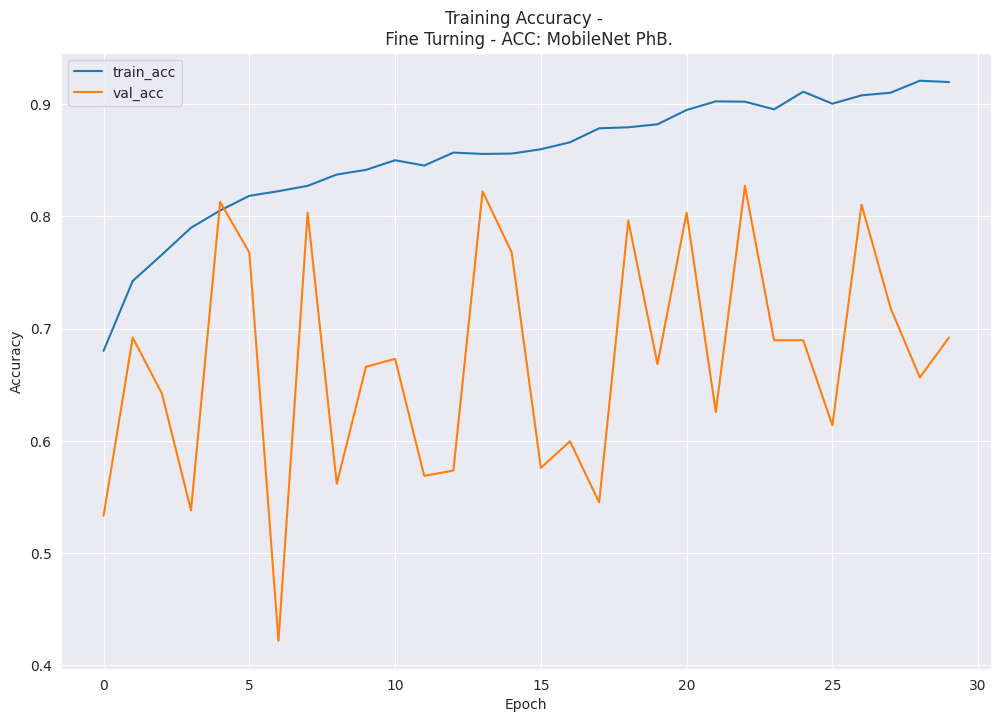

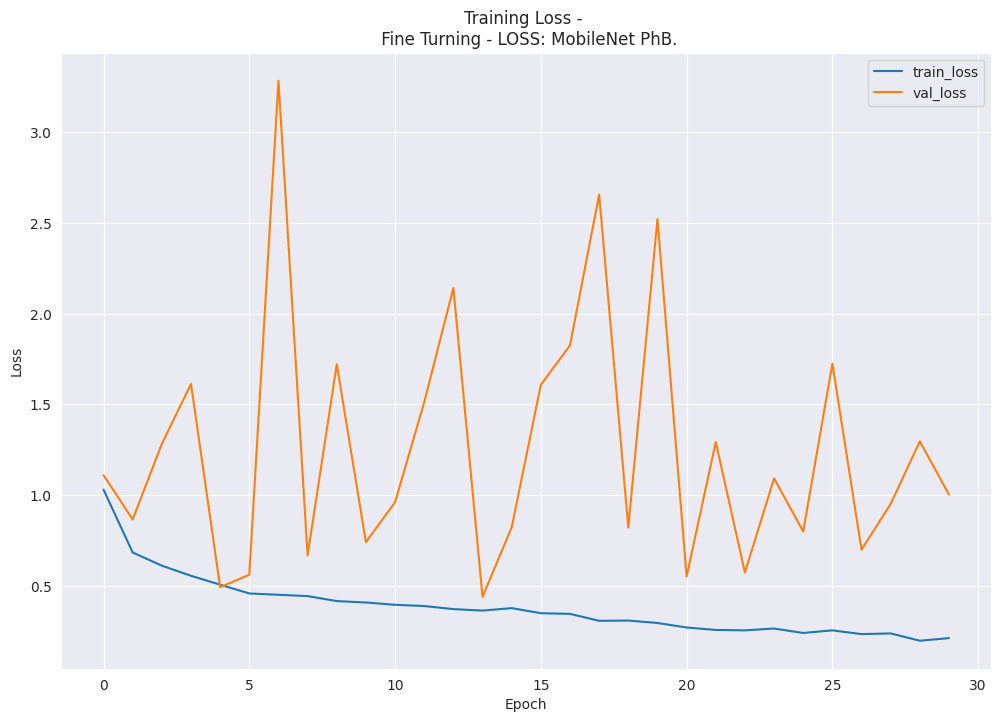

Visualize: y_true, y_pred top 20
Y_true [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 2, 1]
Y_pred [2, 3, 3, 3, 2, 2, 1, 0, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 3, 1]
ACC:       0.8270142180094787
Precision: 0.8310589934177585
Recall:    0.8270142180094787
F1:        0.8256986836272863


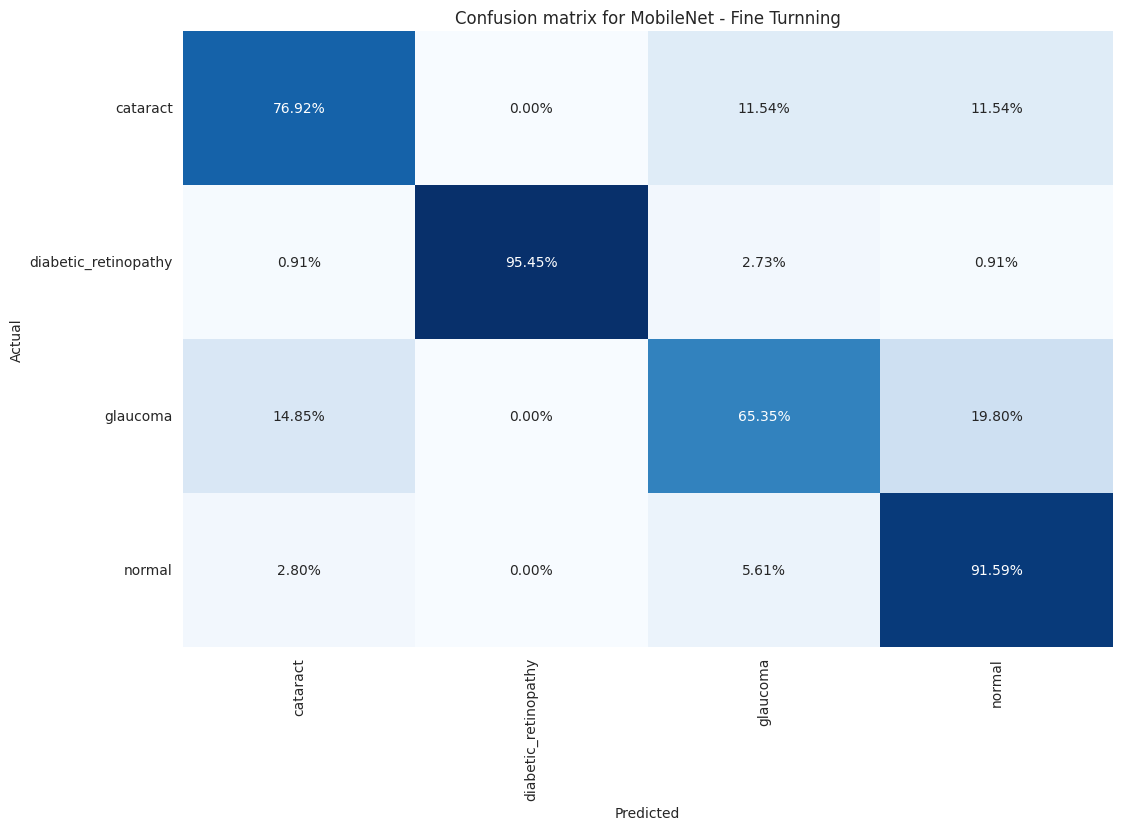

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


==========End Process with model MobileNet==========


87910968/87910968 [==============================] - 1s 0us/step


 ==========Start Process with model InceptionV3=========
Model: "InceptionV3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 chNormalization)                                                                                 
        

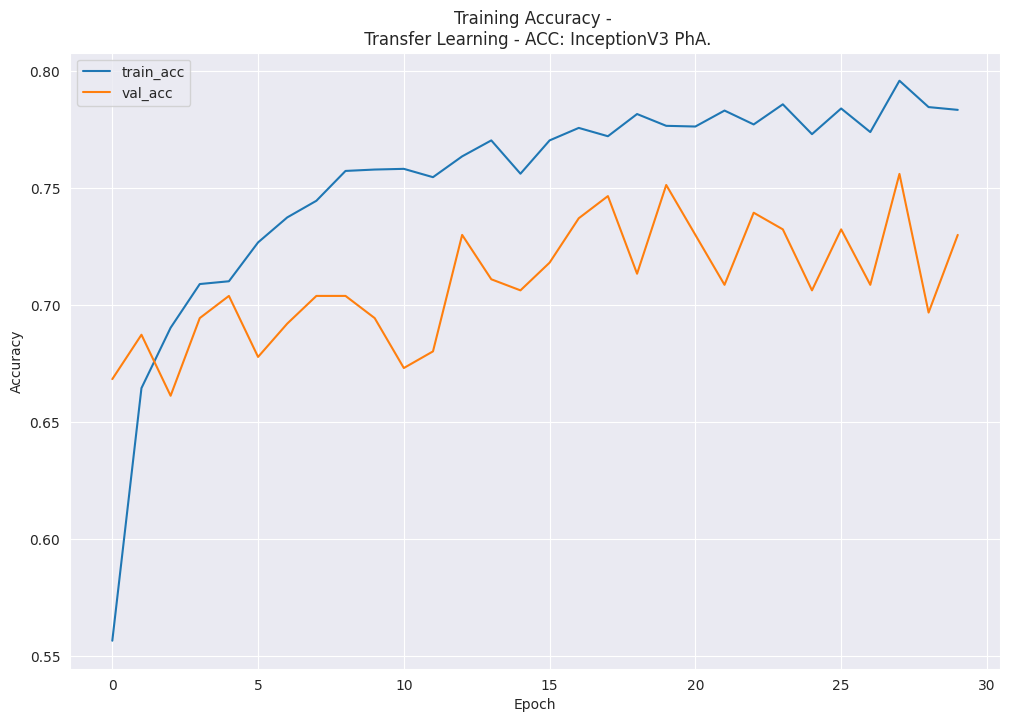

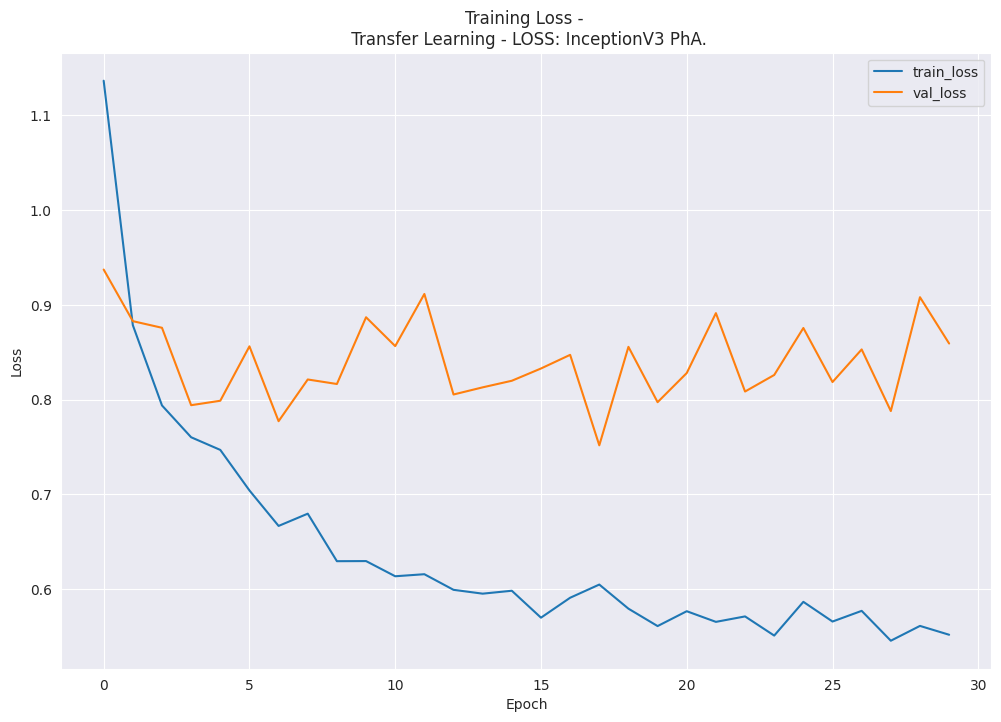

Visualize: y_true, y_pred top 20
Y_true [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 2, 1]
Y_pred [2, 3, 2, 1, 2, 1, 1, 2, 3, 2, 3, 2, 2, 3, 0, 1, 2, 3, 3, 1]
ACC:       0.7630331753554502
Precision: 0.768289519804463
Recall:    0.7630331753554502
F1:        0.7634415783549312


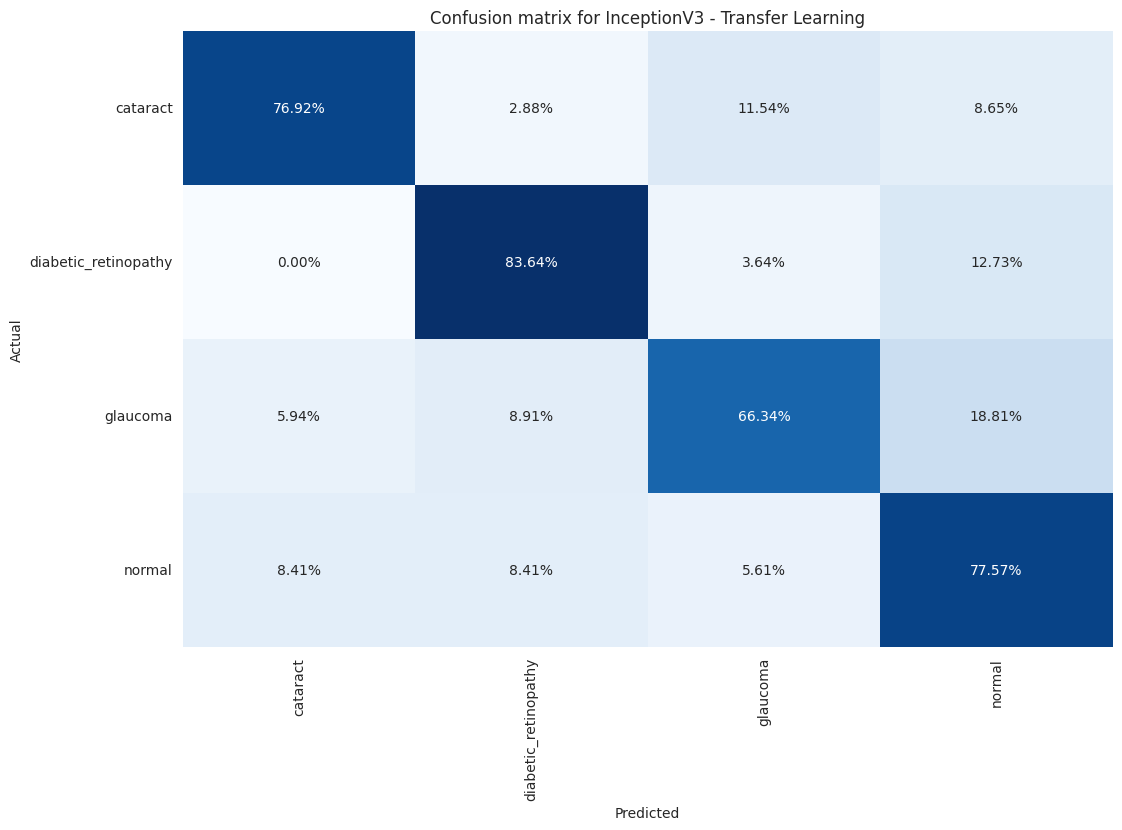

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Epoch 1/30
211/211 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.7406
Epoch 1: val_accuracy improved from -inf to 0.59005, saving model to eye-disease_InceptionV3_ph2_weights.keras
211/211 [==============================] - 15s 43ms/step - loss: 0.7532 - accuracy: 0.7406 - val_loss: 1.0494 - val_accuracy: 0.5900
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.7824
Epoch 2: val_accuracy improved from 0.59005 to 0.67773, saving model to eye-disease_InceptionV3_ph2_weights.keras
211/211 [==============================] - 8s 36ms/step - loss: 0.5898 - accuracy: 0.7824 - val_loss: 0.8401 - val_accuracy: 0.6777
Epoch 3/30
211/211 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.7830
Epoch 3: val_accuracy improved from 0.67773 to 0.69194, saving model to eye-disease_InceptionV3_ph2_weights.keras
211/211 [==============================] - 8s 36ms/step - loss: 0.5830 - accuracy: 0.7830 - val_loss: 0.8521

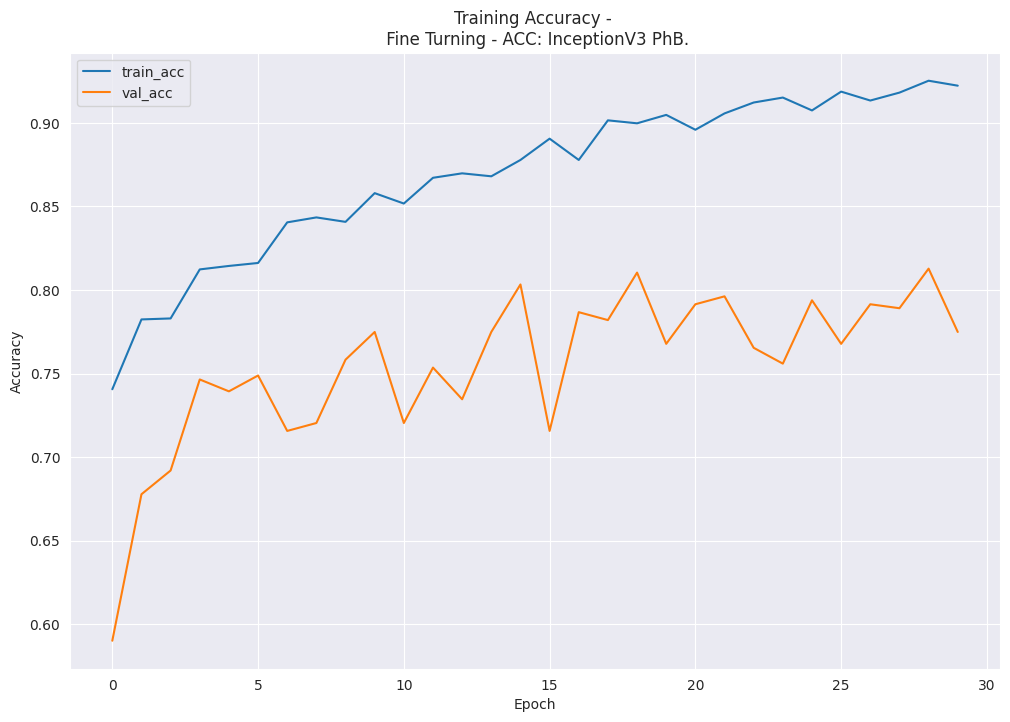

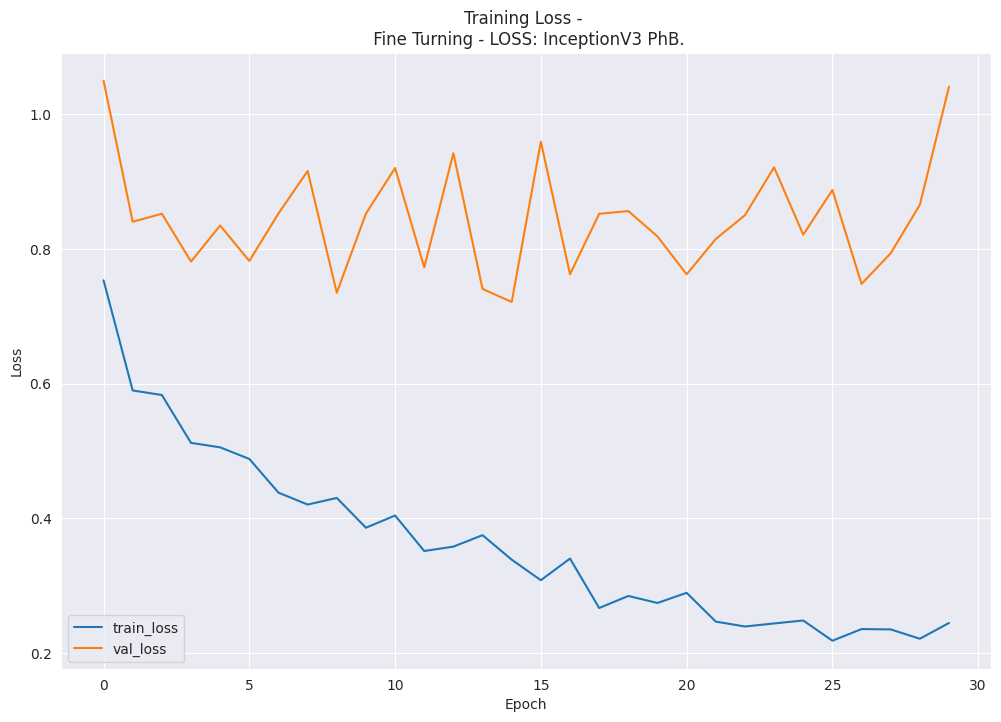

Visualize: y_true, y_pred top 20
Y_true [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 2, 1]
Y_pred [2, 3, 3, 3, 2, 2, 1, 2, 2, 3, 3, 2, 0, 1, 0, 1, 2, 3, 3, 1]
ACC:       0.7890995260663507
Precision: 0.7993020237714037
Recall:    0.7890995260663507
F1:        0.7895919117964968


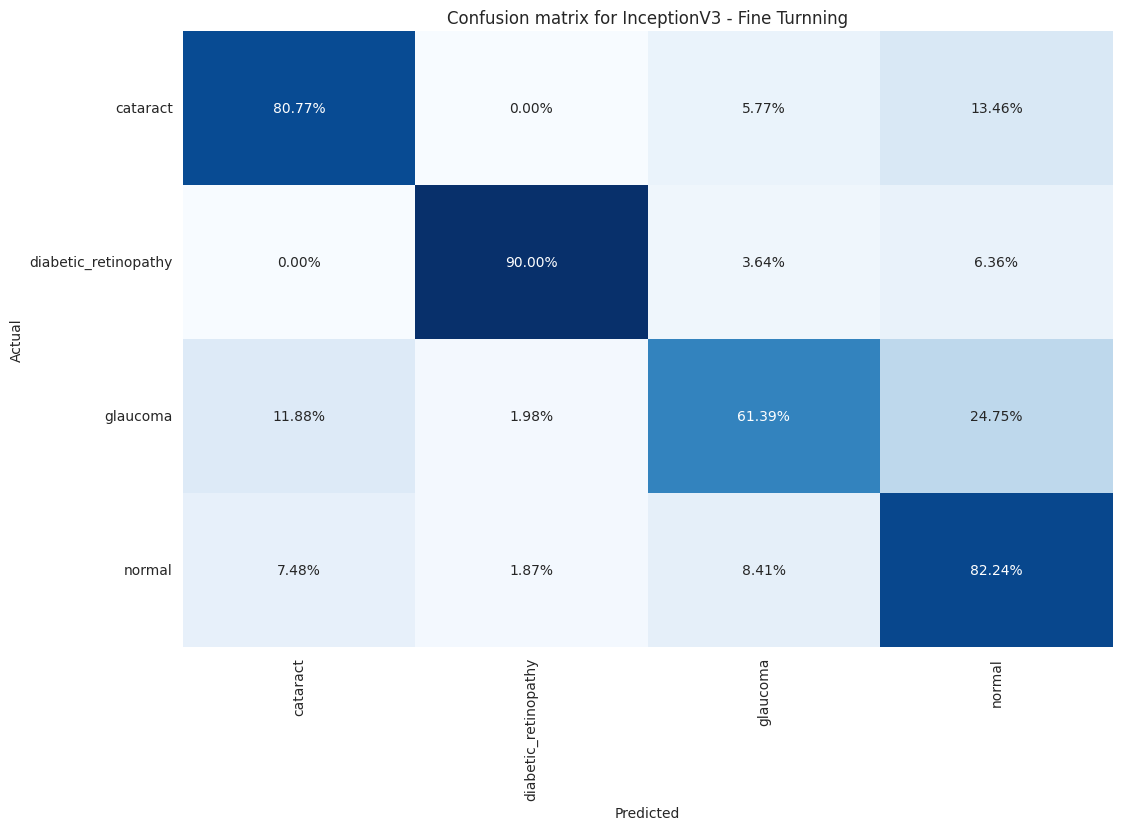

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


==========End Process with model InceptionV3==========


473176280/473176280 [==============================] - 4s 0us/step


 ==========Start Process with model EfficientNetV2L=========
Model: "EfficientNetV2L"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                               

2024-04-30 07:12:50.169897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2L/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


211/211 [==============================] - ETA: 0s - loss: 0.9635 - accuracy: 0.6303
Epoch 1: val_accuracy improved from -inf to 0.75592, saving model to eye-disease_EfficientNetV2L_ph1_weights.keras
211/211 [==============================] - 71s 193ms/step - loss: 0.9635 - accuracy: 0.6303 - val_loss: 0.6307 - val_accuracy: 0.7559
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 0.7524 - accuracy: 0.7272
Epoch 2: val_accuracy improved from 0.75592 to 0.80095, saving model to eye-disease_EfficientNetV2L_ph1_weights.keras
211/211 [==============================] - 32s 150ms/step - loss: 0.7524 - accuracy: 0.7272 - val_loss: 0.5419 - val_accuracy: 0.8009
Epoch 3/30
211/211 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.7477
Epoch 3: val_accuracy did not improve from 0.80095
211/211 [==============================] - 30s 141ms/step - loss: 0.6793 - accuracy: 0.7477 - val_loss: 0.5003 - val_accuracy: 0.7986
Epoch 4/30
211/211 [=================

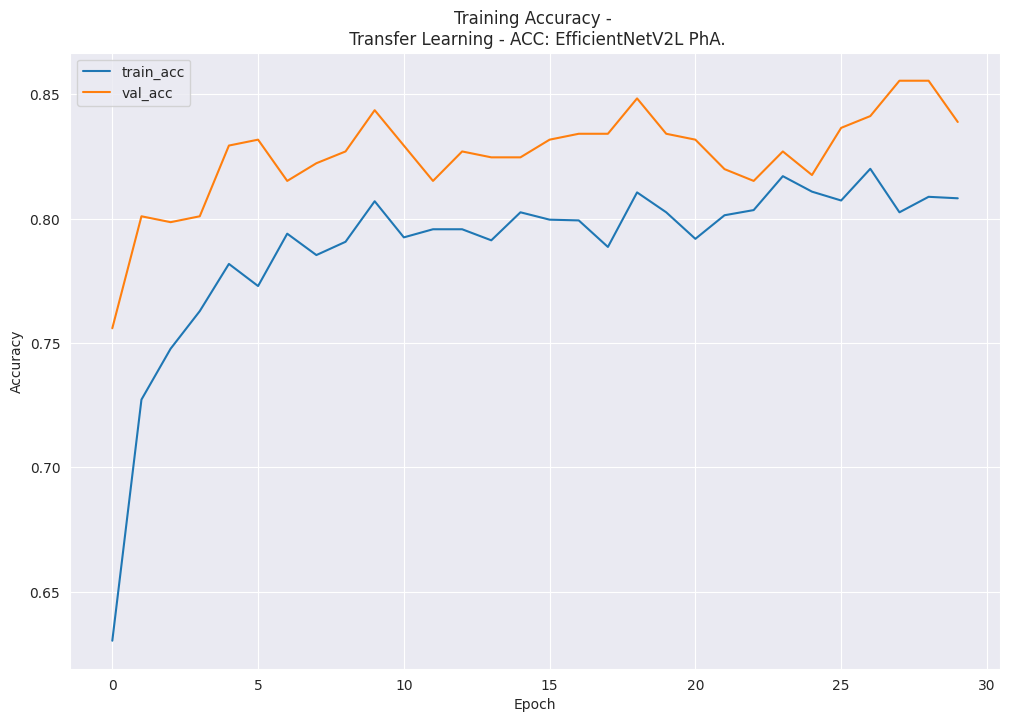

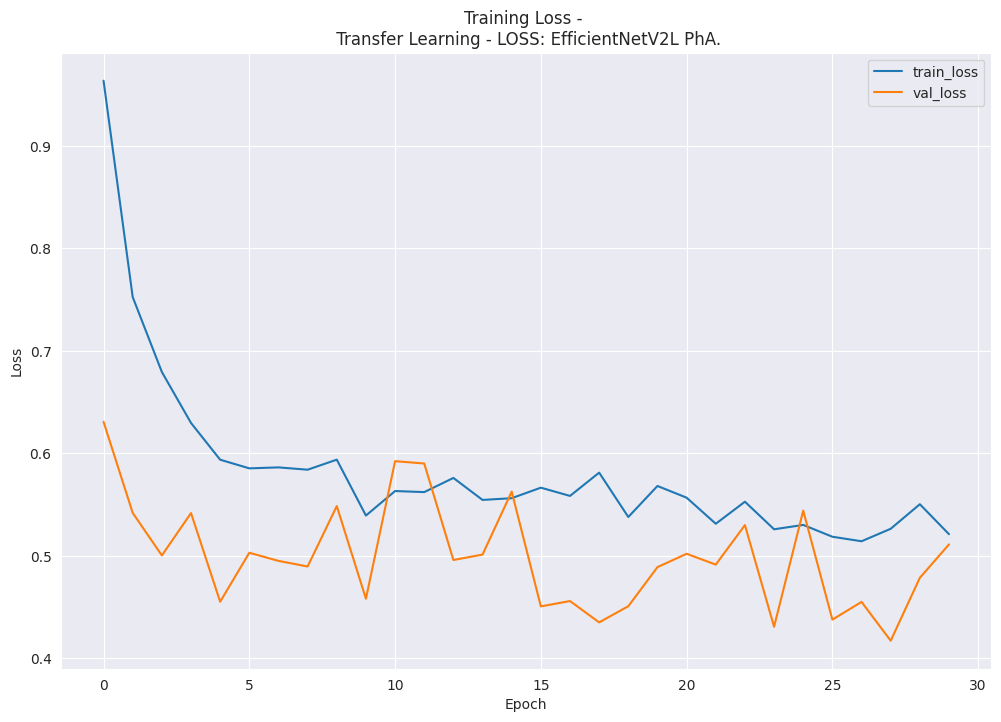

Visualize: y_true, y_pred top 20
Y_true [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 2, 1]
Y_pred [2, 3, 3, 3, 2, 2, 1, 2, 3, 3, 3, 2, 2, 1, 0, 1, 2, 3, 3, 1]
ACC:       0.8412322274881516
Precision: 0.8454764448449978
Recall:    0.8412322274881516
F1:        0.842491122270433


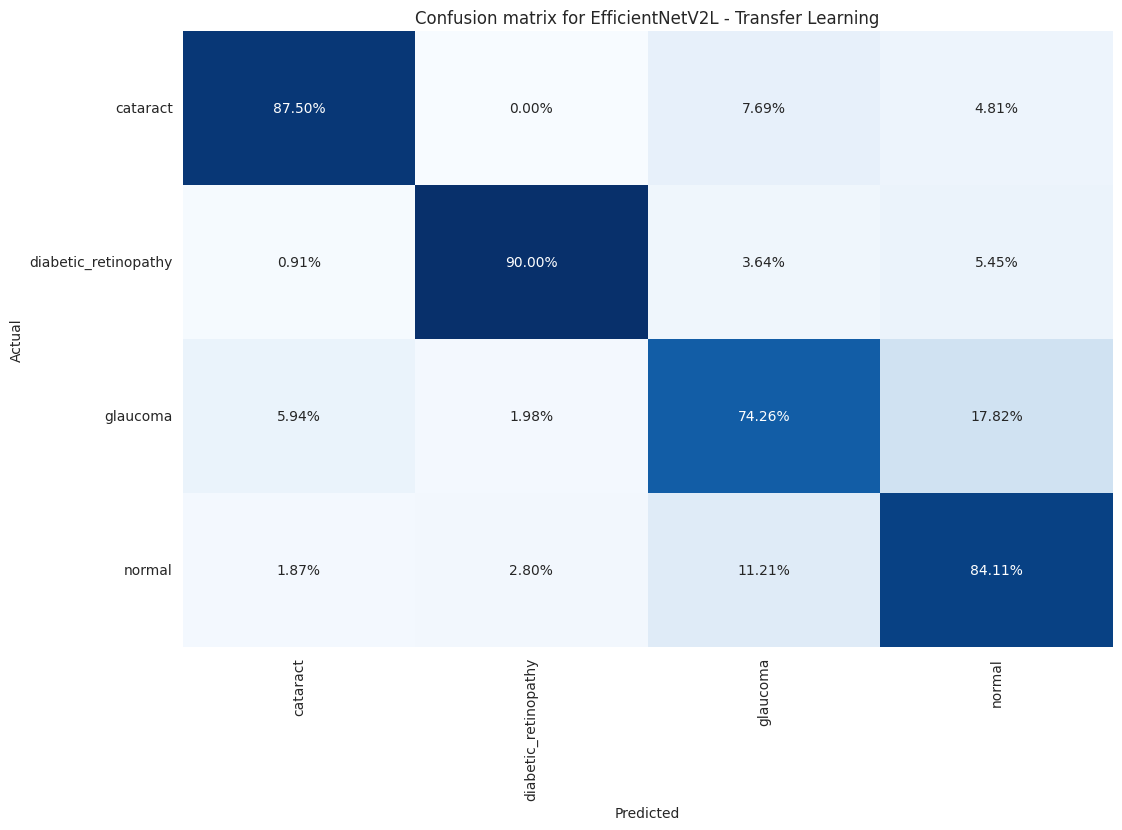

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Epoch 1/30


2024-04-30 07:28:55.878061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2L/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


211/211 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 0.7711
Epoch 1: val_accuracy improved from -inf to 0.84123, saving model to eye-disease_EfficientNetV2L_ph2_weights.keras
211/211 [==============================] - 71s 185ms/step - loss: 0.9452 - accuracy: 0.7711 - val_loss: 0.6203 - val_accuracy: 0.8412
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.8366
Epoch 2: val_accuracy improved from 0.84123 to 0.85308, saving model to eye-disease_EfficientNetV2L_ph2_weights.keras
211/211 [==============================] - 32s 153ms/step - loss: 0.5265 - accuracy: 0.8366 - val_loss: 0.4582 - val_accuracy: 0.8531
Epoch 3/30
211/211 [==============================] - ETA: 0s - loss: 0.4107 - accuracy: 0.8627
Epoch 3: val_accuracy improved from 0.85308 to 0.86493, saving model to eye-disease_EfficientNetV2L_ph2_weights.keras
211/211 [==============================] - 32s 154ms/step - loss: 0.4107 - accuracy: 0.8627 - val_loss: 

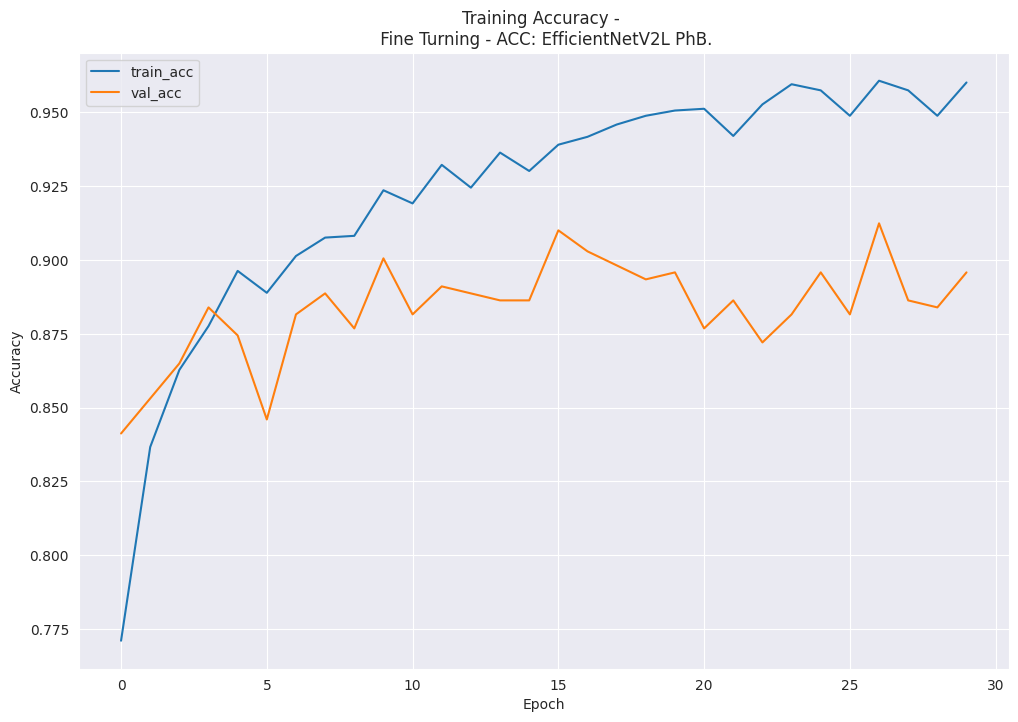

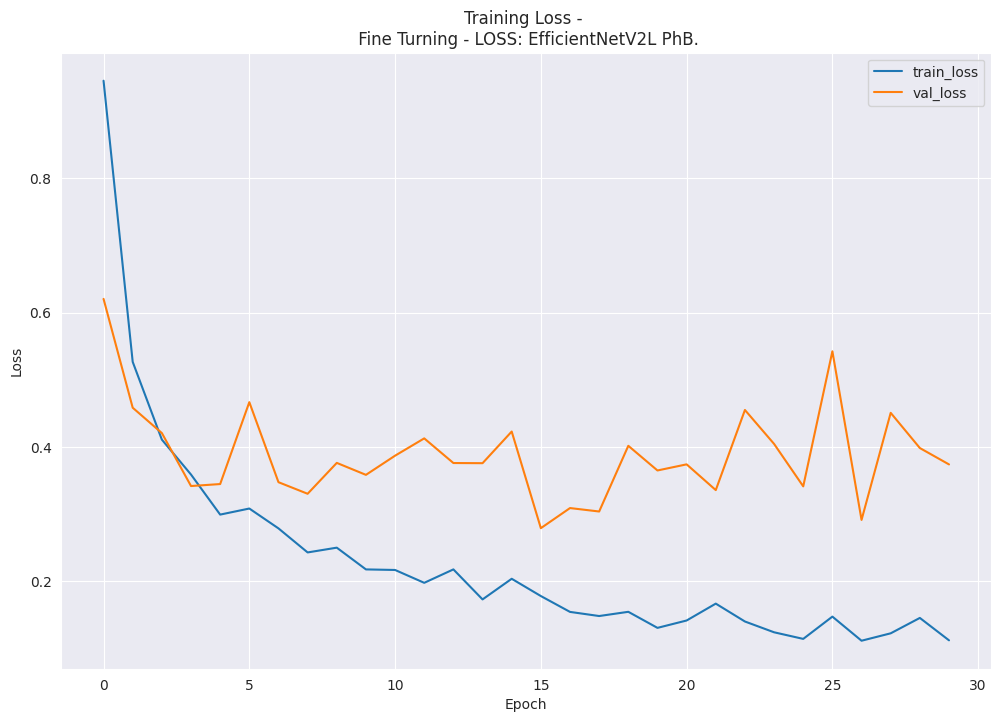

Visualize: y_true, y_pred top 20
Y_true [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 2, 1]
Y_pred [2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 2, 1, 0, 1, 3, 3, 3, 1]
ACC:       0.9241706161137441
Precision: 0.9245688705267517
Recall:    0.9241706161137441
F1:        0.92394379383628


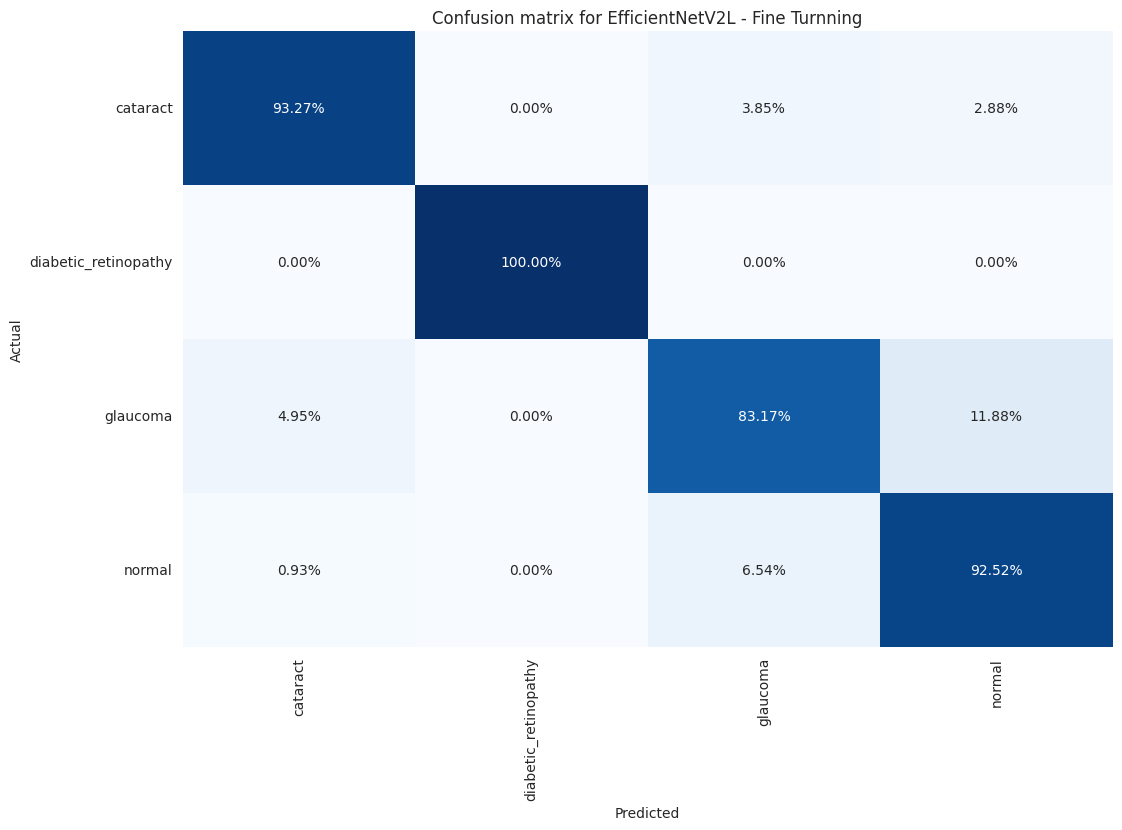

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


==========End Process with model EfficientNetV2L==========




In [22]:
for name, Model in initial_models.items():
    
    base_model = Model(**initial_models_kwargs[name])
    for layer in base_model.layers:
        layer.trainable = False
        
    base_model.trainable = False
    output = base_model.layers[-1].output
    layers = [
        tf.keras.layers.BatchNormalization(),
        Dropout(0.1)
    ]
    
    if USE_HIDDEN_LAYERS:
        for layer in HIDDEN_LAYERS:
            layers.append(
                Dense(
                    layer, activation='relu', 
               )
             )
            layers.append(Dropout(0.1))
            layers.append(tf.keras.layers.BatchNormalization())
            
    layers.append(Dense(len(classes), activation='softmax'))
    
    for layer in layers:
        layer.trainable = True
        output = layer(output)
    
    model = tf.keras.models.Model(base_model.input, output, name=name)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'\n\n ==========Start Process with model {name}=========')
    model.summary()
    
    history, model, best_acc_ph1, y_pred = transfer_learning(model, name)
    calculate_metrics(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {name} - Transfer Learning")
    model.save(name + '_transferlearning.h5')
    
    #best_acc_ph1=0.85
    history, model, best_acc_ph2, y_pred = fine_turning(model, name, best_acc_ph1)
    calculate_metrics(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {name} - Fine Turnning")
    
    model.save(name + '_finetuning.h5')
    
    print(f'==========End Process with model {name}==========\n\n')

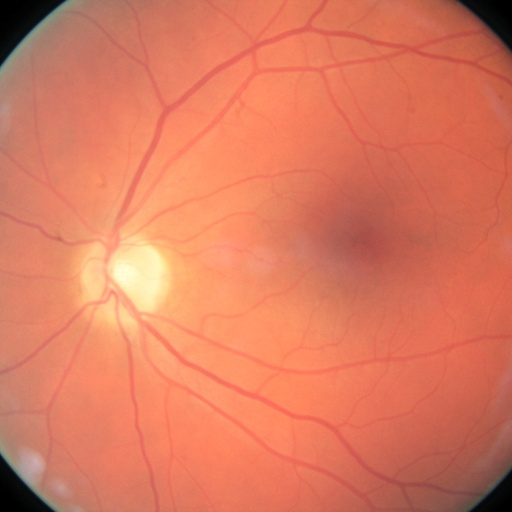

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image, display

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet_v2


# Size of the input image
img_size = (224, 224, 3)

# The local path to our target image
img_path = keras.utils.get_file("/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10032_right.jpeg","/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10032_right.jpeg")
display(Image(img_path))

In [24]:
def get_img_array(img_path, size=(224, 224)):
    # `img` is a PIL image of size 224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = efficientnet_v2.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [25]:
class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self,
        attributions,
        percentage=90,
        connected_component_structure=np.ones((3, 3)),
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        predict_label,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Original: "+ predict_label + ", Predict: "+ predict_label)
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
    
        plt.show()


In [26]:
def decode_predictions_class(y_pred, top=5):
    """
    Decodes predictions for a 4-class classification problem.

    Args:
      y_pred: A numpy array of shape (num_samples, num_classes) containing
          predicted probabilities.
      top: (int) number of top predictions to return.

    Returns:
      A list of lists containing the top `top` predictions for each sample.
      Each inner list contains a tuple of (class_name, probability).
    """
    # Get class indices and probabilities
    class_indices = np.argsort(y_pred, axis=-1)[:, -top:][:, ::-1]
    probabilities = y_pred[np.arange(len(y_pred))[:, None], class_indices]

    # Define your class labels (modify these as needed)
    class_labels = classes

    # Create the list of predictions
    predictions = []
    for sample_preds, sample_probs in zip(class_indices, probabilities):
        predictions.append([(class_labels[i], prob) for i, prob in zip(sample_preds, sample_probs)])

    return predictions

In [27]:
# 1. Convert the image to numpy array
img = get_img_array(img_path)

# 2. Keep a copy of the original image
orig_img = np.copy(img[0]).astype(np.uint8)

# 3. Preprocess the image
img_processed = np.expand_dims(img[0],axis=0)

# 4. Get model predictions
preds = model.predict(img_processed)
print(preds)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", top_pred_idx, decode_predictions_class(preds, top=1)[0])

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img_processed, top_pred_idx=top_pred_idx)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=50, num_runs=4
)



1/1 [==============================] - 8s 8s/step
[[4.0280740e-10 1.0000000e+00 1.5185236e-10 4.2781291e-08]]
Predicted: tf.Tensor(1, shape=(), dtype=int64) [('diabetic_retinopathy', 1.0)]


In [28]:
# 7. Process the gradients and plot
vis = GradVisualizer()
predict_label = decode_predictions_class(preds, top=1)[0][0][0]

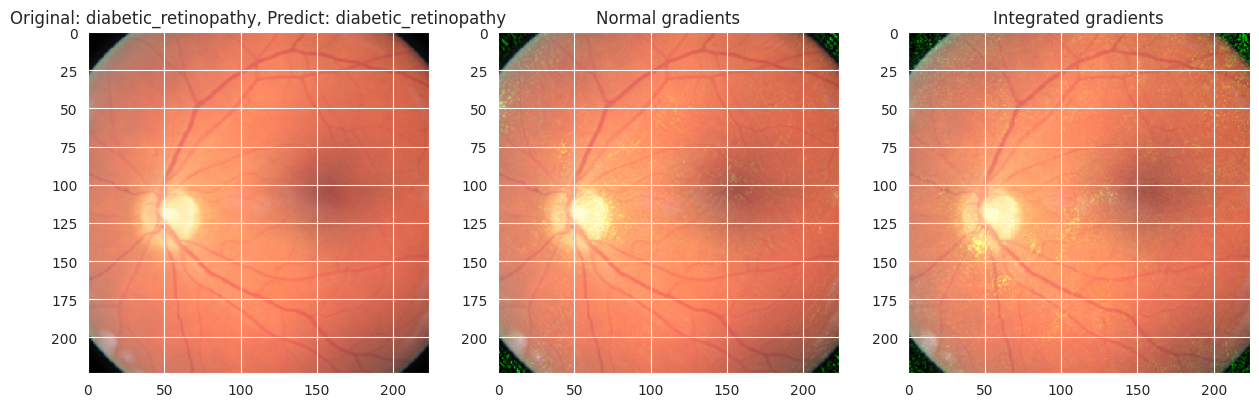

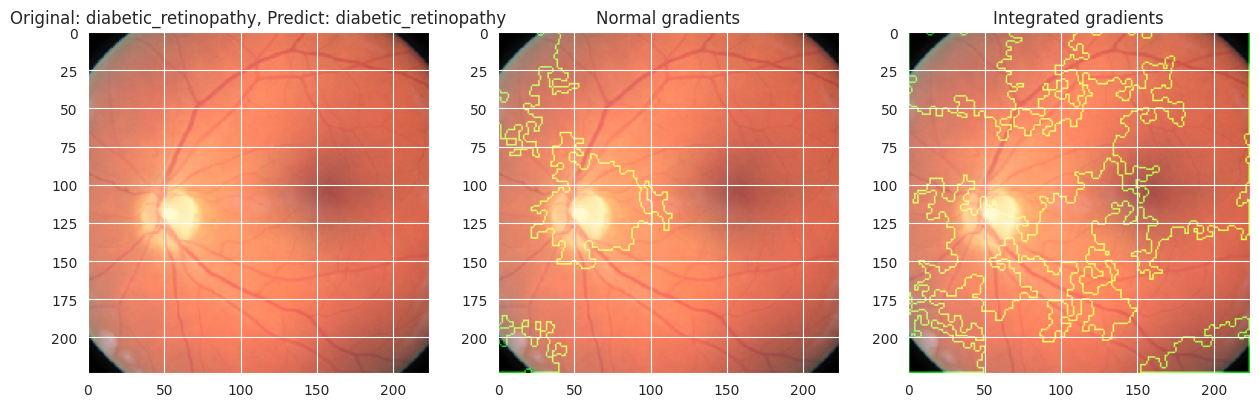

In [29]:
vis.visualize(
    image=orig_img,
    predict_label=predict_label,
    gradients=grads[0],
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    predict_label=predict_label,
    gradients=grads[0],
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
    morphological_cleanup=True,
    outlines=True,
)